Mitq tutorial: https://mitiq.readthedocs.io/en/stable/examples/ibmq-backends.html

# Imports

In [5]:
import numpy as np
from numpy.ma.core import shape

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise

from functools import partial

from utils.pce_vs_zne_utils import *

import qiskit
import itertools
from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

from utils.pauli_checks import ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list
from utils.pauli_checks import gen_initial_layout, gen_final_layout, complete_postprocess, filter_results

from utils.pauli_checks import convert_to_PCS_circ # new util

from utils.utils import norm_dict, total_counts
# from utils.vqe_utils import evaluation

from qiskit_aer import QasmSimulator

from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

from functools import partial

from utils.pce_vs_zne_utils import *

from qiskit_ibm_runtime.fake_provider import *
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from itertools import combinations

import os
import csv
import re
from collections import defaultdict

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

#### Backend settings

In [6]:
USE_REAL_HARDWARE = False

In [7]:
# Fake backend noise model
# fake_backend = FakeMelbourneV2()
# noise_model = noise.NoiseModel.from_backend(fake_backend)

# Custom nosie model
prob_1 = 0.002  # 1-qubit gate
prob_2 = 0.02  # 2-qubit gate

error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'], ['cz'])

In [8]:
if QiskitRuntimeService.saved_accounts() and USE_REAL_HARDWARE:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    noise_model = False
else:
    backend = AerSimulator(noise_model=noise_model)
    # backend = AerSimulator.from_backend(fake_backend)

# Tests

In [17]:
# circuit parameters
num_qubits = 8
num_circs = 20

# observable we're estimating
pauli_string = 'Z' * num_qubits

# pce parameters
num_checks = num_qubits//2
print(f"num_checks = {num_checks}")
num_checks_to_fit = num_checks
extrap_checks = range(num_checks_to_fit + 1, num_qubits + 1)
only_Z_checks = True

# zne parameters
# zne_method = "linear"
verbose = True

num_checks = 4


20


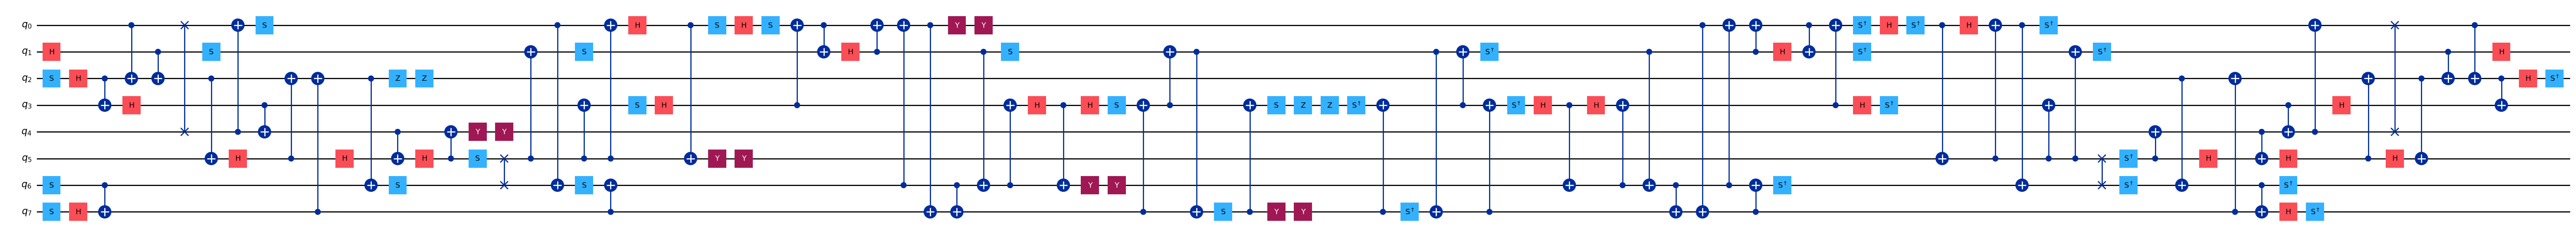

In [18]:
cliff_circs = random_cliff_circs(num_qubits, num_circs)
print(len(cliff_circs))
cliff_circs[-1].draw("mpl", fold=-1)

In [19]:
ideal_expectations = []
for circ in cliff_circs:
    ideal_expect = get_ideal_expectation(circ, pauli_string)
    ideal_expectations.append(ideal_expect)

# print(ideal_expectations)

In [20]:
pcs_circs = [[] for _ in range(num_circs)]
signs_list = [[] for _ in range(num_circs)]

for i, circ in enumerate(cliff_circs):
    print("i =", i+1, "out of", num_circs)
    for check_id in range(1, num_checks + 1):
        print("check_id =", check_id)
        sign, pcs_circ = convert_to_PCS_circ(circ, num_qubits, check_id, only_Z_checks=only_Z_checks)
        pcs_circs[i].append(pcs_circ)
        signs_list[i].append(sign)

print(len(pcs_circs))
print(len(pcs_circs[0]))
# print(signs_list)

i = 1 out of 20
check_id = 1
trying  ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: +1IIIIIIIZ, +1IIIIIIIZ
Required number of checks found.
p1_list =  [['+1IIIIIIIZ', '+1IIIIIIIZ']]
check_id = 2
trying  ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: +1IIIIIIIZ, +1IIIIIIIZ
trying  ['I', 'I', 'I', 'I', 'I', 'I', 'Z', 'I']
Found check 2: +1IIIIIIZI, +1IIIIIIZI
Required number of checks found.
p1_list =  [['+1IIIIIIIZ', '+1IIIIIIIZ'], ['+1IIIIIIZI', '+1IIIIIIZI']]
check_id = 3
trying  ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: +1IIIIIIIZ, +1IIIIIIIZ
trying  ['I', 'I', 'I', 'I', 'I', 'I', 'Z', 'I']
Found check 2: +1IIIIIIZI, +1IIIIIIZI
trying  ['I', 'I', 'I', 'I', 'I', 'Z', 'I', 'I']
Found check 3: +1IIIIIZII, +1IIIIIZII
Required number of checks found.
p1_list =  [['+1IIIIIIIZ', '+1IIIIIIIZ'], ['+1IIIIIIZI', '+1IIIIIIZI'], ['+1IIIIIZII', '+1IIIIIZII']]
check_id = 4
trying  ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: +1IIIIIIIZ, +1IIIIIIIZ
trying  

In [21]:
# List of ZNE methods
zne_methods_list = ["linear", "richardson"]
zne_avg_errors = {}

# Run the circuits for each ZNE method
for zne_m in zne_methods_list:
    zne_abs_errors = []
    print(f"Running ZNE tests with method: {zne_m}")
    
    for i, circ in enumerate(cliff_circs):
        # Run mitigation with the chosen ZNE method
        zne_exp = mitigate_zne(circ, backend, pauli_string, method=zne_m)
        print(f"ZNE ({zne_m}) mitigated exp for {pauli_string}: {zne_exp}")
        print(f"Ideal expectation = {ideal_expectations[i]}")
        
        abs_error = np.abs(ideal_expectations[i] - zne_exp)
        zne_abs_errors.append(abs_error)
    
    avg_error = np.mean(zne_abs_errors)
    zne_avg_errors[ f"ZNE_{zne_m}" ] = avg_error
    print(f"Average absolute error for ZNE ({zne_m}): {avg_error:.5f}")


Running ZNE tests with method: linear
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.27919999999999995
Ideal expectation = (0.9999999999999942+0j)
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.34740000000000015
Ideal expectation = (0.9999999999999916-9.321026924400951e-34j)
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.23986666666666673
Ideal expectation = (0.9999999999999927+1.5830470874080784e-50j)
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.3476
Ideal expectation = (0.9999999999999931+2.4008418932645563e-51j)
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.33880000000000005
Ideal expectation = (0.9999999999999933+5.424208267216815e-51j)
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.24773333333333333
Ideal expectation = (0.9999999999999938-1.5502035318534735e-49j)
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.2505333333333334
Ideal expectation = (0.9999999999999922-3.8242251019955407e-34j)
ZNE (linear) mitigated exp for ZZZZZZZZ: 0.19453333333333334
Ideal expectation = (0.999999999999994+4.276423536147513

In [22]:
pce_abs_errors = []
for i, cliff_circ in enumerate(cliff_circs):
    print(f"Processing PCE for circuit {i+1} out of {num_circs}")
    expectation_values = []
    for j in range(num_checks):
        pcs_circ = pcs_circs[i][j]
        signs = signs_list[i][j]
        expectation_value = ibmq_executor_pcs(pcs_circ, backend=backend, pauli_string=pauli_string, num_qubits=num_qubits, signs=signs)
        expectation_values.append(expectation_value)
    
    extrapolated_values, polynomial = extrapolate_checks(num_checks_to_fit, extrap_checks, expectation_values)
    pce_exp = extrapolated_values[-1]
    
    print(f"PCE exp for {pauli_string}: {pce_exp}")
    print(f"Ideal expectation = {ideal_expectations[i]}")
    abs_error = np.abs(ideal_expectations[i] - pce_exp)
    print(f"Absolute error = {abs_error}")
    pce_abs_errors.append(abs_error)

pce_avg_error = np.mean(pce_abs_errors)
print(f"Average absolute error for PCE: {pce_avg_error:.5f}")


Processing PCE for circuit 1 out of 20
PCE exp for ZZZZZZZZ: 1.008430857596323
Ideal expectation = (0.9999999999999942+0j)
Absolute error = 0.008430857596328778
Processing PCE for circuit 2 out of 20
PCE exp for ZZZZZZZZ: 1.1740941767359474
Ideal expectation = (0.9999999999999916-9.321026924400951e-34j)
Absolute error = 0.17409417673595584
Processing PCE for circuit 3 out of 20
PCE exp for ZZZZZZZZ: 0.7928001642168448
Ideal expectation = (0.9999999999999927+1.5830470874080784e-50j)
Absolute error = 0.20719983578314782
Processing PCE for circuit 4 out of 20
PCE exp for ZZZZZZZZ: 1.1847764243307826
Ideal expectation = (0.9999999999999931+2.4008418932645563e-51j)
Absolute error = 0.18477642433078945
Processing PCE for circuit 5 out of 20
PCE exp for ZZZZZZZZ: 0.965638958535048
Ideal expectation = (0.9999999999999933+5.424208267216815e-51j)
Absolute error = 0.03436104146494534
Processing PCE for circuit 6 out of 20
PCE exp for ZZZZZZZZ: 1.0140510087032788
Ideal expectation = (0.99999999999

In [23]:
# Combine all errors in a single dictionary
avg_errors = zne_avg_errors.copy()  # includes both ZNE_linear and ZNE_default
avg_errors["PCE"] = pce_avg_error

print(avg_errors)

{'ZNE_linear': 0.7149799999999932, 'ZNE_richardson': 0.4969999999999929, 'PCE': 0.0903187214610134}


In [24]:
circ_folder = "rand_cliffs_new"
file_name = f"avg_errors_n={num_qubits}_num_circs={num_circs}_num_samp={10_000}.csv"
save_avg_errors(circ_folder, file_name, avg_errors, overwrite=True)

Results successfully saved to data_PCE_vs_ZNE/rand_cliffs_new/avg_errors_n=8_num_circs=20_num_samp=10000.csv


# Plots

In [ ]:
# Set the directory and parameters to match your saved CSV file.
data_dir = "data_PCE_vs_ZNE/rand_cliffs"  # Change this if you use a different subfolder.
num_circs = 20  # Must match the number used when saving.
num_samples = 10_000  # Must match the number used when saving.

# Load the saved average errors.
data = load_avg_errors(data_dir, num_circs=num_circs, num_samples=num_samples)
print("Loaded data:")
print(data)

# Plot the data.
# It creates a grouped bar chart comparing all methods (e.g., ZNE_LINEAR, ZNE_DEFAULT, PCE, etc.)
plot_save_path = os.path.join(data_dir, "error_plot.png")
plot_avg_errors_by_qubit(data, num_samples=num_samples, num_circs=num_circs, save_path=plot_save_path)